# **Генерация географических данных**
- **ноутбуки лучше просматривать** на Github pages, т.к. при просмотре прямо в репозитории могут быть проблемы с отображением, например, обрезка вывода с широкими датафреймами. **Если в адресной строке браузера есть** `iaroslav-dzh.github.io`, то вы уже на Github pages.  
Ссылки:
    -  **[Ссылка](https://iaroslav-dzh.github.io/fraud_txns_simulator/notebooks/02_%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D0%B3%D0%B5%D0%BE_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85.html)** на этот ноутбук
    -  **[Ссылка](https://iaroslav-dzh.github.io/fraud_txns_simulator/02_Страница_генератора_транзакций.html)** на страницу генератора где есть все ноутбуки  

**Информация о ноутбуке**
- загрузка геоданных российских городов и добавление их к данным клиентов
- замена чешских районов на российские города
- создание функции генерации случайных координат внутри городоа

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import geopandas as gpd
from shapely.geometry import Point, Polygon
import random
import pyarrow
from data_generator.utils import load_configs

In [2]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)

In [3]:
os.chdir("..")
os.getcwd()

'c:\\Users\\iaros\\My_documents\\Education\\projects\\fraud_detection_01'

In [5]:
# Загрузка базовых конфигов
base_cfg = load_configs("./config/base.yaml")

# Пути к файлам
data_paths = base_cfg["data_paths"]

In [6]:
clients = pd.read_csv(data_paths["cleaned"]["clients"])
district = pd.read_csv(data_paths["cleaned"]["districts"])

In [7]:
print(district.shape)
district.head(1)

(77, 16)


,district_code,district_name,region,population,no_of_mun_below_500,no_of_mun_between_500_1999,no_of_mun_between_2000_9999,no_of_mun_above_10000,no_of_cities,ratio_of_urban_population,avg_salary,unemployment_rate_95,unemployment_rate_96,enterpreneurs_per_1000,crimes_num_95,crimes_num_96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677.0,99107


In [8]:
district_short = district[["district_code","district_name", "region", "population"]].sort_values("population", ascending=False).reset_index(drop=True)
district_short.head()

,district_code,district_name,region,population
0,1,Hl.m. Praha,Prague,1204953
1,54,Brno - mesto,south Moravia,387570
2,74,Ostrava - mesto,north Moravia,323870
3,70,Karvina,north Moravia,285387
4,68,Frydek - Mistek,north Moravia,228848


In [9]:
# посчитаем клиентов по районам. Это нужно для дальнейшей замены чешских районов

clients_by_dist = clients.groupby("district_id", as_index=False).agg({"client_id":"count"}) \
                        .rename(columns={"client_id":"clients"})

In [10]:
# соединим district_short и clieints_by_dist чтобы отсортировать районы по количеству клиентов в дальнейшем

district_short = district_short.merge(clients_by_dist, left_on="district_code", right_on="district_id")
print(district_short.shape)
district_short.head()

(77, 6)


,district_code,district_name,region,population,district_id,clients
0,1,Hl.m. Praha,Prague,1204953,1,663
1,54,Brno - mesto,south Moravia,387570,54,155
2,74,Ostrava - mesto,north Moravia,323870,74,180
3,70,Karvina,north Moravia,285387,70,169
4,68,Frydek - Mistek,north Moravia,228848,68,86


# **Замена чешских районов на российские города**
С целью чтобы упростить в дальнейшем процесс реалистичной генерации координат транзакций клиентов, я решил заменить чешские районы на российские города.
Далее мы проверим насколько схожи профиля городов России и районов Чехии. Но сильное сходство нам не нужно

<br>

## 1. Загрузка российских городов. Очистка данных

In [9]:
# список российских городов с населением и другой информацией
# "https://gist.githubusercontent.com/dnovik/694d106be3ff20eb0c73a0511c83b7f3/raw/056b7ece3b762723c02d3809ef77e2ae92a2bcd0/cities.csv"

In [11]:
russian_cities = pd.read_csv(r"./data/raw/russian_cities.csv")

In [12]:
russian_cities.head()

,Индекс,Тип региона,Регион,Тип района,Район,Тип города,Город,Тип н/п,Н/п,Код КЛАДР,Код ФИАС,Уровень по ФИАС,Признак центра района или региона,Код ОКАТО,Код ОКТМО,Код ИФНС,Часовой пояс,Широта,Долгота,Федеральный округ,Население
0,385200.0,Респ,Адыгея,NaN,NaN,г,Адыгейск,NaN,NaN,100000200000,ccdfd496-8108-4655-aadd-bd228747306d,4: город,0,79403000000,7.970300e+10,107,UTC+3,44.878372,39.190172,Южный,12689
1,385000.0,Респ,Адыгея,NaN,NaN,г,Майкоп,NaN,NaN,100000100000,8cfbe842-e803-49ca-9347-1ef90481dd98,4: город,2,79401000000,7.970100e+10,105,UTC+3,44.609827,40.100653,Южный,144055
2,649000.0,Респ,Алтай,NaN,NaN,г,Горно-Алтайск,NaN,NaN,400000100000,0839d751-b940-4d3d-afb6-5df03fdd7791,4: город,2,84401000000,8.470100e+07,400,UTC+7,51.958268,85.960296,Сибирский,62861
3,658125.0,край,Алтайский,NaN,NaN,г,Алейск,NaN,NaN,2200000200000,ae716080-f27b-40b6-a555-cf8b518e849e,4: город,0,1403000000,1.703000e+06,2201,UTC+7,52.492091,82.779415,Сибирский,28528
4,656000.0,край,Алтайский,NaN,NaN,г,Барнаул,NaN,NaN,2200000100000,d13945a8-7017-46ab-b1e6-ede1e89317ad,4: город,2,1401000000,1.701000e+06,2200,UTC+7,53.348115,83.779836,Сибирский,635585


In [13]:
# создадим маппинг для переименования колонок

ru_cities_col_mapping = {"Регион":"region", "Город":"city", "Часовой пояс":"timezone", "Широта":"lat", "Долгота":"lon", "Население":"population_ru"}

In [14]:
# переименуем нужные нам колонки и оставим только их. Население приведем к типу int

ru_cities_short = russian_cities.rename(columns=ru_cities_col_mapping).loc[:, ru_cities_col_mapping.values()].copy()

In [15]:
ru_cities_short.dtypes

region            object
city              object
timezone          object
lat              float64
lon              float64
population_ru     object
dtype: object

In [16]:
# проверим на значения в population где кроме чисел есть что-то еще
# отфильтруем по булевой маске: сперва создадим массив с булевыми значениями,
# где True это совпадение с regex - у нас regex проверяет является ли строка числом с количеством цифр от 1 до 8
# через тильду ~ мы инвертируем этот массив. И у нас теперь True это все строки где кроме цельного числа есть что-то еще в строке
# ^ начало строки. $ конец строки. \d{1,8} это значит "числа, от 1 до 8 чисел подряд"

dirty_records = ru_cities_short[~ru_cities_short.population_ru.str.match(r"^\d{1,8}$")].population_ru
ru_cities_short.loc[dirty_records.index]

,region,city,timezone,lat,lon,population_ru
923,Татарстан,Иннополис,UTC+3,55.752154,48.744616,96[3]


In [17]:
# создадим дубликат колонки для дальнейших изменений в ней. Чтобы можно было коротко сверить что значения для остальных записей
# остались прежними

ru_cities_short.loc[:, "popul_ru_clean"] = ru_cities_short.loc[:, "population_ru"]

In [18]:
# извлечем чистые числа из грязных значений. Отфильтруем по индексу для изменения и вставки значений
# сделаем этом кусок кода масштабируемым на случай если у нас изменятся исходные данные - прибавятся новые и т.п.

ru_cities_short.loc[dirty_records.index, "popul_ru_clean"] = ru_cities_short.loc[dirty_records.index, "population_ru"] \
                                                                .str.findall(r"\d{1,8}").str[0]

In [19]:
ru_cities_short.head()

,region,city,timezone,lat,lon,population_ru,popul_ru_clean
0,Адыгея,Адыгейск,UTC+3,44.878372,39.190172,12689,12689
1,Адыгея,Майкоп,UTC+3,44.609827,40.100653,144055,144055
2,Алтай,Горно-Алтайск,UTC+7,51.958268,85.960296,62861,62861
3,Алтайский,Алейск,UTC+7,52.492091,82.779415,28528,28528
4,Алтайский,Барнаул,UTC+7,53.348115,83.779836,635585,635585


In [20]:
ru_cities_short.tail()

,region,city,timezone,lat,lon,population_ru,popul_ru_clean
1107,Ярославская,Ростов,UTC+3,57.205018,39.437836,31791,31791
1108,Ярославская,Рыбинск,UTC+3,58.048380,38.858338,200771,200771
1109,Ярославская,Тутаев,UTC+3,57.867424,39.536823,41001,41001
1110,Ярославская,Углич,UTC+3,57.522387,38.301979,34505,34505
1111,Ярославская,Ярославль,UTC+3,57.621614,39.897878,591486,591486


In [21]:
# удалим колонку population_ru со старыми значениями

ru_cities_short.drop(columns="population_ru", inplace=True)

In [22]:
# приведем значения в колонке к int

ru_cities_short["popul_ru_clean"] = ru_cities_short.loc[:, "popul_ru_clean"].astype("int")

In [23]:
ru_cities_short.head()

,region,city,timezone,lat,lon,popul_ru_clean
0,Адыгея,Адыгейск,UTC+3,44.878372,39.190172,12689
1,Адыгея,Майкоп,UTC+3,44.609827,40.100653,144055
2,Алтай,Горно-Алтайск,UTC+7,51.958268,85.960296,62861
3,Алтайский,Алейск,UTC+7,52.492091,82.779415,28528
4,Алтайский,Барнаул,UTC+7,53.348115,83.779836,635585


In [24]:
ru_cities_short.dtypes

region             object
city               object
timezone           object
lat               float64
lon               float64
popul_ru_clean      int64
dtype: object

In [25]:
# Проверим на пустые значения

nan_city = ru_cities_short[ru_cities_short.isna().any(axis=1)]
nan_city

,region,city,timezone,lat,lon,popul_ru_clean
506,Москва,NaN,UTC+3,55.753879,37.620373,11514330
782,Санкт-Петербург,NaN,UTC+3,59.939125,30.315822,4848742
863,Севастополь,NaN,UTC+3,44.616733,33.525355,344479
1066,Чеченская,NaN,UTC+3,43.127607,45.540684,49071


In [26]:
# город из Чеченской республики узнаем по координатам и заполним вручную. Остальные названия возьмем из region

ru_cities_short.loc[(ru_cities_short.lat == 43.1276072) & (ru_cities_short.lon == 45.5406838), "city"] = "Урус-Мартан"

In [27]:
# заполняем остальное

ru_cities_short["city"] = ru_cities_short["city"].fillna(ru_cities_short["region"])

In [28]:
# проверим результат

ru_cities_short.loc[(ru_cities_short.lat.isin(nan_city.lat)) & (ru_cities_short.lon.isin(nan_city.lon))]

,region,city,timezone,lat,lon,popul_ru_clean
506,Москва,Москва,UTC+3,55.753879,37.620373,11514330
782,Санкт-Петербург,Санкт-Петербург,UTC+3,59.939125,30.315822,4848742
863,Севастополь,Севастополь,UTC+3,44.616733,33.525355,344479
1066,Чеченская,Урус-Мартан,UTC+3,43.127607,45.540684,49071


In [29]:
# количество чешских районов в data berka 

district_short.shape[0]

77

In [30]:
# значит нужно 77 первых по населению городов РФ

ru_77_cities = ru_cities_short.sort_values("popul_ru_clean", ascending=False).copy().reset_index(drop=True).loc[0:76]

In [31]:
# первые 5 и последние 5 записей урезанного до 77 городов датафрейма

ru_77_cities.iloc[np.r_[0:5,-5:0]]

,region,city,timezone,lat,lon,popul_ru_clean
0,Москва,Москва,UTC+3,55.753879,37.620373,11514330
1,Санкт-Петербург,Санкт-Петербург,UTC+3,59.939125,30.315822,4848742
2,Новосибирская,Новосибирск,UTC+7,55.028102,82.921058,1498921
3,Свердловская,Екатеринбург,UTC+5,56.838633,60.605489,1377738
4,Нижегородская,Нижний Новгород,UTC+3,56.324209,44.005395,1250615
72,Карелия,Петрозаводск,UTC+3,61.789090,34.359626,263540
73,Ростовская,Таганрог,UTC+3,47.209491,38.935154,257692
74,Ханты-Мансийский Автономный округ - Югра,Нижневартовск,UTC+5,60.939738,76.569621,251860
75,Марий Эл,Йошкар-Ола,UTC+3,56.634376,47.899845,248688
76,Иркутская,Братск,UTC+8,56.151395,101.633989,246348


In [32]:
# количество записей

ru_77_cities.shape

(77, 6)

<br>

## 2. Сравнение профилей численности населения чешских районов и российских городов
- Насколько подходит замена чешских районов на российские города?

### **А. Сравним коэффиценты изменчивости численности населения для чешских районов и для российских городов**

Формула коэффициента: cv = standard deviation / mean * 100

In [33]:
cz_mean_pop = district_short.population.mean()
cz_pop_std = district_short.population.std()
czech_cv = cz_pop_std / cz_mean_pop * 100


print(f"""Czech variability coefficient: {czech_cv:.2f}%""")

Czech variability coefficient: 102.26%


In [34]:
ru_mean_pop = ru_77_cities.popul_ru_clean.mean()
ru_pop_std = ru_77_cities.popul_ru_clean.std()

ru_cv = ru_pop_std / ru_mean_pop * 100

print(f"""Russian variability coefficient: {ru_cv:.2f}%""")

Russian variability coefficient: 183.48%


In [35]:
# во сколько раз российский коэффициент изменчивости больше чешского

print(f"""Russian population cv is {ru_cv / czech_cv:.2f} times higher than czech cv""")

Russian population cv is 1.79 times higher than czech cv


### **Вывод по коэффициентам изменчивости**
В России отклонение от среднего почти в два раза больше чем Чехии

### **Б. Сравним процент населения от столицы в Чехии и России**

In [36]:
czech_pop_perc_from_max = district_short.population.div(district_short.population.max()).mul(100).round(2)

In [37]:
ru_pop_perc_from_max = ru_77_cities.popul_ru_clean.div(ru_77_cities.popul_ru_clean.max()).mul(100).round(2)

In [38]:
pop_perc_from_capital = pd.concat([czech_pop_perc_from_max, ru_pop_perc_from_max], axis=1) \
                                .rename(columns={"population":"pop_perc_cz","popul_ru_clean":"pop_perc_ru"}) \
                                .query("pop_perc_cz < 100 and pop_perc_ru < 100")
pop_perc_from_capital.head()

,pop_perc_cz,pop_perc_ru
1,32.16,42.11
2,26.88,13.02
3,23.68,11.97
4,18.99,10.86
5,18.77,10.57


#### Посмотрим на графике

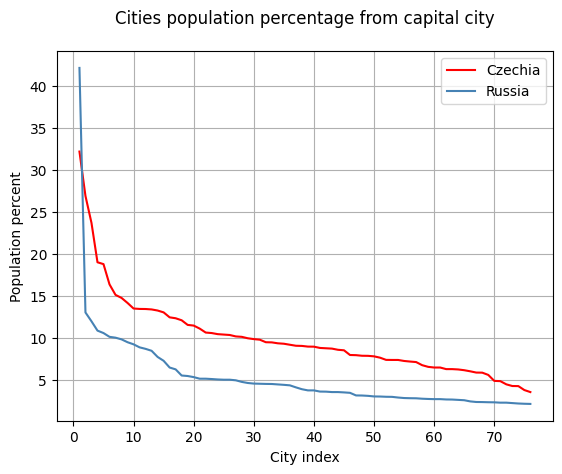

In [39]:
fig, ax = plt.subplots()

sns.lineplot(data=pop_perc_from_capital, x=pop_perc_from_capital.index, y="pop_perc_cz", label="Czechia", color="red", ax=ax)
sns.lineplot(data=pop_perc_from_capital, x=pop_perc_from_capital.index, y="pop_perc_ru", label="Russia", color="steelblue", ax=ax)
ax.grid(which="both")
ax.set_title("Cities population percentage from capital city", pad=20)
ax.set_xlabel("City index")
ax.set_ylabel("Population percent");

### **Вывод по проценту населения относительно столицы**
В России он меньше, кроме первого города в сравнении - С.Петербурга  
Но динамика в целом схожа. Так что остановимся на выборе российских городов для замены в датасете.


## 3. Непосредственно замена районов на города РФ

In [40]:
cities_ru = ru_77_cities.copy()

In [41]:
# отсортируем district_short по количеству клиентов в районе, по убыванию. 
# Чтобы у нас в дальнейшей замене динамика населения городов России совпадала с количеством клиентов в городах

district_short = district_short.sort_values("clients", ascending=False).reset_index(drop=True)
district_short.iloc[np.r_[0:5,-5:0]] # первые 5 и последние 5 записей

,district_code,district_name,region,population,district_id,clients
0,1,Hl.m. Praha,Prague,1204953,1,663
1,74,Ostrava - mesto,north Moravia,323870,74,180
2,70,Karvina,north Moravia,285387,70,169
3,54,Brno - mesto,south Moravia,387570,54,155
4,64,Zlin,south Moravia,197099,64,109
72,12,Pribram,central Bohemia,107870,12,44
73,65,Znojmo,south Moravia,114200,65,44
74,58,Jihlava,south Moravia,109164,58,44
75,24,Karlovy Vary,west Bohemia,122603,24,43
76,20,Strakonice,south Bohemia,70646,20,43


In [42]:
# просто берем отсортированные по количеству клиентов коды районов и добавляем в датафрейм с российскими городами

cities_ru["district_code"] = district_short.district_code

In [43]:
# количество колонок в cities_ru
cities_ru_col_number = cities_ru.shape[1]

In [44]:
# переставим добавленную колонку district_code в начало
# для этого создадим список с желаемыми позициями колонок. последняя позиция + список позиций с 0 до предпоследней
cities_cols_reorder = [-1] + list(range(cities_ru.shape[1] - 1))
district_ru = cities_ru.iloc[:, cities_cols_reorder].copy()

In [45]:
# Сверим количество колонок после перестановки

if cities_ru_col_number > cities_ru.shape[1]:
    raise ValueError(f"""Initial cols number is bigger than current cols number for cities_ru:
Initial cols shape: {cities_ru_col_number}
Current cols shape: {cities_ru.shape[1]}""")

elif cities_ru_col_number < cities_ru.shape[1]:
    raise ValueError(f"""Initial cols number is less than current cols number for cities_ru:
Initial cols shape: {cities_ru_col_number}
Current cols shape: {cities_ru.shape[1]}""")  

else:
    print(f"""Initial cols and current cols number are identical:
Initial cols shape: {cities_ru_col_number}
Current cols shape: {cities_ru.shape[1]}""") 
    

Initial cols and current cols number are identical:
Initial cols shape: 7
Current cols shape: 7


In [46]:
# добавим также количество клиентов.

cities_ru["clients"] = district_short.clients

In [47]:
# переименуем popul_ru_clean

cities_ru = cities_ru.rename(columns={"popul_ru_clean":"population"})

In [48]:
cities_ru.iloc[np.r_[0:5, -5:0]] # первые 5 и последние 5 записей

,region,city,timezone,lat,lon,population,district_code,clients
0,Москва,Москва,UTC+3,55.753879,37.620373,11514330,1,663
1,Санкт-Петербург,Санкт-Петербург,UTC+3,59.939125,30.315822,4848742,74,180
2,Новосибирская,Новосибирск,UTC+7,55.028102,82.921058,1498921,70,169
3,Свердловская,Екатеринбург,UTC+5,56.838633,60.605489,1377738,54,155
4,Нижегородская,Нижний Новгород,UTC+3,56.324209,44.005395,1250615,64,109
72,Карелия,Петрозаводск,UTC+3,61.789090,34.359626,263540,12,44
73,Ростовская,Таганрог,UTC+3,47.209491,38.935154,257692,65,44
74,Ханты-Мансийский Автономный округ - Югра,Нижневартовск,UTC+5,60.939738,76.569621,251860,58,44
75,Марий Эл,Йошкар-Ола,UTC+3,56.634376,47.899845,248688,24,43
76,Иркутская,Братск,UTC+8,56.151395,101.633989,246348,20,43


In [49]:
# проверим форму district_ru после всех изменений

cities_ru.shape

(77, 8)

<br><br>

# **Получение геополигонов городов России. Написание генератора координат внутри геополигона города**

<br>

## 1. Работа с сырыми геоданными
- получение геополигонов (границ) городов 

In [50]:
geo_files = os.listdir("./data/raw/geo/")
geo_files[:5]

['01_central_ru.cpg',
 '01_central_ru.dbf',
 '01_central_ru.prj',
 '01_central_ru.shp',
 '01_central_ru.shx']

In [51]:
[file for file in geo_files if re.match(r".+\.shp", file)]

['01_central_ru.shp',
 '02_crimea_ru.shp',
 '03_far_east_ru.shp',
 '04_caucasus_ru.shp',
 '05_northwest_ru.shp',
 '06_siberia_ru.shp',
 '07_south_ru.shp',
 '08_ural_ru.shp',
 '09_volga_ru.shp']

**Загрузка геоданных**
- города и их геополигоны (координаты границ)

In [52]:
ru_cities_tentative = pd.concat([gpd.read_file(f"./data/raw/geo/{file}") \
                       .query("fclass =='city' or fclass =='town'") for file in geo_files if re.match(r".+\.shp", file)], \
                     ignore_index=True)

In [53]:
# сузим данные, отфильтровав по именам городов из cities_ru

ru_cities_tent_subset = ru_cities_tentative.loc[ru_cities_tentative.name.isin(cities_ru.city)]


In [54]:
# проверка на одинаковые названия городов

ru_cities_tent_subset[ru_cities_tent_subset.duplicated("name", keep=False)]

,osm_id,code,fclass,population,name,geometry
300,3401282,1002,town,0,Киров,"POLYGON ((34.22729 54.09437, 34.23057 54.09479..."
2671,2383150,1001,city,521091,Киров,"MULTIPOLYGON (((49.34343 58.4958, 49.34606 58...."


In [55]:
# Удалим дубликаты. Ставим флаг keep='last', чтобы оставить последний из дубликатов

ru_cities_tent_subset = ru_cities_tent_subset.drop_duplicates(subset="name", keep='last')

ru_cities_tent_subset.head()

,osm_id,code,fclass,population,name,geometry
242,930950,1001,city,425000,Тверь,"MULTIPOLYGON (((35.72142 56.83594, 35.72156 56..."
315,3134925,1001,city,503216,Липецк,"MULTIPOLYGON (((39.37977 52.62677, 39.38317 52..."
388,389790,1001,city,401505,Иваново,"POLYGON ((40.86788 56.99265, 40.87023 56.99384..."
432,3348896,1001,city,449556,Курск,"POLYGON ((36.0603 51.67692, 36.06039 51.67947,..."
438,1991003,1001,city,352347,Владимир,"MULTIPOLYGON (((40.16496 56.12132, 40.16772 56..."


In [56]:
# проверим форму датафрейма

ru_cities_tent_subset.shape

(76, 6)

**Не хватает одного города, должно быть 77. Проверим какого**

In [57]:
# сделаем булеву маску и инвертируем ее значения.
# Покажет True для города, который не в ru_cities_tent_subset, но есть в cities_ru

cities_ru[~cities_ru.city.isin(ru_cities_tent_subset.name)]

,region,city,timezone,lat,lon,population,district_code,clients
25,Дагестан,Махачкала,UTC+3,42.984857,47.50463,577990,51,61


In [58]:
# создадим вручную геополигон для Махачкалы на сайте https://geojson.io. Загрузим этот .geojson файл как geodataframe
# после соединения датафреймов, мы заполним недостающие данные для Махачкалы

makhachkala_poly = gpd.read_file("./data/raw/geo/makhachkala.geojson")
makhachkala_poly

,geometry
0,"POLYGON ((47.51911 42.90425, 47.53096 42.90538..."


<Axes: >

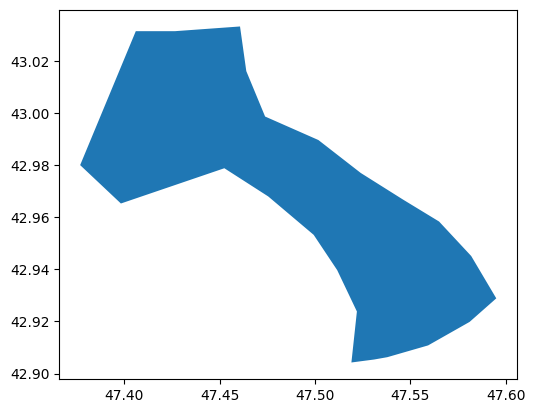

In [59]:
# график чтобы проверить, что полигон правильно загрузился

makhachkala_poly.plot() 

In [60]:
# сузим датафрейм с гео данными до двух колонок

ru_cities_tent = ru_cities_tent_subset.loc[:, ["name", "geometry"]].copy().reset_index(drop=True)
ru_cities_tent.head()

,name,geometry
0,Тверь,"MULTIPOLYGON (((35.72142 56.83594, 35.72156 56..."
1,Липецк,"MULTIPOLYGON (((39.37977 52.62677, 39.38317 52..."
2,Иваново,"POLYGON ((40.86788 56.99265, 40.87023 56.99384..."
3,Курск,"POLYGON ((36.0603 51.67692, 36.06039 51.67947,..."
4,Владимир,"MULTIPOLYGON (((40.16496 56.12132, 40.16772 56..."


<br>

## 2. Соедининение `cities_ru` и датафрейма с гео данными

In [61]:
cities_ru_merge = cities_ru.merge(ru_cities_tent, how='left', left_on="city", right_on="name")
cities_ru_merge.head(3)

,region,city,timezone,lat,lon,population,district_code,clients,name,geometry
0,Москва,Москва,UTC+3,55.753879,37.620373,11514330,1,663,Москва,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55...."
1,Санкт-Петербург,Санкт-Петербург,UTC+3,59.939125,30.315822,4848742,74,180,Санкт-Петербург,"POLYGON ((30.04334 59.76418, 30.04535 59.76553..."
2,Новосибирская,Новосибирск,UTC+7,55.028102,82.921058,1498921,70,169,Новосибирск,"MULTIPOLYGON (((82.75113 54.99103, 82.75147 54..."


In [62]:
# проверка где не хватает значений после джоина

cities_ru_merge[cities_ru_merge.isna().any(axis=1)]

,region,city,timezone,lat,lon,population,district_code,clients,name,geometry
25,Дагестан,Махачкала,UTC+3,42.984857,47.50463,577990,51,61,NaN,None


In [63]:
# заполним данные о полигоне для Махачкалы

cities_ru_merge.loc[cities_ru_merge.city == "Махачкала", "geometry"] = makhachkala_poly.iloc[0,0]
cities_ru_merge.loc[cities_ru_merge.city == "Махачкала"]

,region,city,timezone,lat,lon,population,district_code,clients,name,geometry
25,Дагестан,Махачкала,UTC+3,42.984857,47.50463,577990,51,61,NaN,"POLYGON ((47.51911 42.90425, 47.53096 42.90538..."


In [ ]:
# удалим колонку name и clients. Они не нужны

cities_ru_merge.drop(columns=["name","clients",] inplace=True)

In [70]:
cities_ru_merge.head(3)

,region,city,timezone,lat,lon,population,city_id,geometry
0,Москва,Москва,UTC+3,55.753879,37.620373,11514330,1,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55...."
1,Санкт-Петербург,Санкт-Петербург,UTC+3,59.939125,30.315822,4848742,74,"POLYGON ((30.04334 59.76418, 30.04535 59.76553..."
2,Новосибирская,Новосибирск,UTC+7,55.028102,82.921058,1498921,70,"MULTIPOLYGON (((82.75113 54.99103, 82.75147 54..."


In [71]:
# проверим форму

cities_ru_merge.shape

(77, 8)

In [72]:
# остались ли пустые значения

cities_ru_merge.isna().sum()

region        0
city          0
timezone      0
lat           0
lon           0
population    0
city_id       0
geometry      0
dtype: int64

In [68]:
# переименуем колонку district_code в city_id

cities_ru_merge = cities_ru_merge.rename(columns={"district_code":"city_id"})
cities_ru_merge.head(3)

,region,city,timezone,lat,lon,population,city_id,clients,geometry
0,Москва,Москва,UTC+3,55.753879,37.620373,11514330,1,663,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55...."
1,Санкт-Петербург,Санкт-Петербург,UTC+3,59.939125,30.315822,4848742,74,180,"POLYGON ((30.04334 59.76418, 30.04535 59.76553..."
2,Новосибирская,Новосибирск,UTC+7,55.028102,82.921058,1498921,70,169,"MULTIPOLYGON (((82.75113 54.99103, 82.75147 54..."


### **Выгрузка `cities_ru_merge` в файл**

In [73]:
# выгрузим датафрейм т.к. он будет использоваться в других ноутбуках

cities_ru_merge = gpd.GeoDataFrame(cities_ru_merge, geometry="geometry", crs="EPSG:4326")
cities_ru_merge.to_file(data_paths["base"]["cities"], layer='layer_name', driver="GPKG")

<br>

## 3. Создание геодатафрейма с точками координат центров городов

In [75]:
# создадим отдельный датафрейм для точек центра городов. Пригодится в дальнейшем.

city_centers_gdf = cities_ru_merge[["city", "lat", "lon"]].copy()

In [76]:
# Сделаем из двух колонок lat и lon колонку с точкой координат центра города

city_centers_gdf["city_center"] = pd.Series(list(zip(city_centers_gdf.lon, city_centers_gdf.lat))).apply(Point)

In [77]:
city_centers_gdf = gpd.GeoDataFrame(city_centers_gdf, geometry="city_center", crs="EPSG:4326")

In [78]:
# проверим форму

city_centers_gdf.shape

(77, 4)

In [79]:
# типы данных

city_centers_gdf.dtypes

city             object
lat             float64
lon             float64
city_center    geometry
dtype: object

In [80]:
city_centers_gdf.head()

,city,lat,lon,city_center
0,Москва,55.753879,37.620373,POINT (37.62037 55.75388)
1,Санкт-Петербург,59.939125,30.315822,POINT (30.31582 59.93912)
2,Новосибирск,55.028102,82.921058,POINT (82.92106 55.0281)
3,Екатеринбург,56.838633,60.605489,POINT (60.60549 56.83863)
4,Нижний Новгород,56.324209,44.005395,POINT (44.00539 56.32421)


### **Выгрузка `city_centers_gdf` в файл**

In [81]:
city_centers_gdf.to_file(data_paths["base"]["city_centers"], layer='layer_name', driver="GPKG")

<br>

## 4. Функция генерации случайных координат внутри городов
- нужна для создания координат оффлайн мерчантов

### **А. Пример генерации координат внутри карты города**
- Равномерное распределение точек

In [82]:
# функция генерации случайных точек в указанной зоне
# это не сам полигон города, а четырехугольник из крайних точек полигона города

def Random_Points_in_Bounds(polygon, number):   
    minx, miny, maxx, maxy = polygon.bounds
    x = np.random.uniform( minx, maxx, number )
    y = np.random.uniform( miny, maxy, number )
    return x, y

In [83]:
# пример полигона
nn_poly = cities_ru_merge.query("city == 'Нижний Новгород'").loc[:,"geometry"].iloc[0]

In [84]:
# геодатафрейм с полигоном города

gdf_poly = gpd.GeoDataFrame(index=["myPoly"], geometry=[nn_poly])

In [85]:
# сгенерировать 500 точек в четырехугольнике

x,y = Random_Points_in_Bounds(nn_poly, 500)
# pandas датафрейм для точек
df = pd.DataFrame()
# сделать кортежи с парами координат
df['points'] = list(zip(x,y))
# перевести кортежи в тип Point
df['points'] = df['points'].apply(Point)
# создать геодатафрейм из pandas датафрейма с точками
gdf_points = gpd.GeoDataFrame(df, geometry='points')

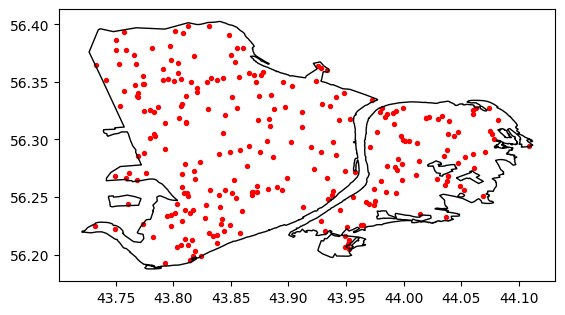

In [86]:
# space join. Соединение сгенерированных точек с полигоном города
Sjoin = gpd.tools.sjoin(gdf_points, gdf_poly, predicate="within", how='left')

# оставить только совпадения с gdf_poly
pnts_in_poly = gdf_points[Sjoin.index_right=='myPoly']

# Построим график с результатом
base = gdf_poly.boundary.plot(linewidth=1, edgecolor="black")
pnts_in_poly.plot(ax=base, linewidth=1, color="red", markersize=8)
plt.show()

### **Б. Функция генерации координат внутри города(полигона)**

In [87]:
def gen_trans_coordinates(polygon, number):
    """
    Функция генерации координат внутри города(полигона)
    """
    x,y = Random_Points_in_Bounds(polygon, number)
    df = pd.DataFrame()
    df['points'] = list(zip(x,y))
    df['points'] = df['points'].apply(Point)
    gdf_points = gpd.GeoDataFrame(df, geometry='points')

    gdf_poly = gpd.GeoDataFrame(index=["myPoly"], geometry=[polygon])
    
    Sjoin = gpd.tools.sjoin(gdf_points, gdf_poly, predicate="within", how='left')

    # Оставить точки внутри "myPoly"
    pnts_in_poly = gdf_points[Sjoin.index_right=='myPoly']

    return pnts_in_poly, gdf_poly

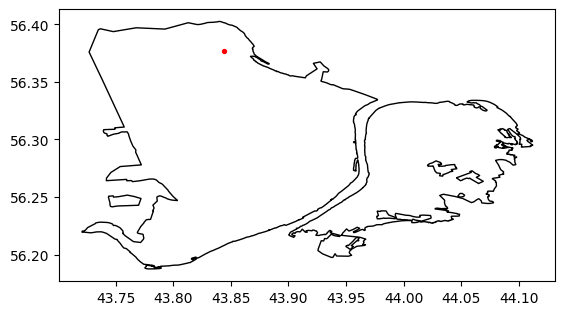

In [88]:
#  Проверим функцию
pnts_in_poly = gpd.GeoDataFrame()
gdf_poly = gpd.GeoDataFrame()

while pnts_in_poly.empty:
    pnts_in_poly, gdf_poly = gen_trans_coordinates(nn_poly, 1)

base = gdf_poly.boundary.plot(linewidth=1, edgecolor="black")
pnts_in_poly.plot(ax=base, linewidth=1, color="red", markersize=8)
plt.show()